## Redes Convolucionales
#### Ejemplo clasificación de perros y gatos para CAPTCHA

Este notebook utiliza datos de la [competición de Kaggle Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/overview). En esta competicion se utiliza Asirra (Animal Species Image Recognition for Restricting Access), CAPTCHA que sirve para diferenciar entre una persona o una máquina accediendo a una página web. Este tipo de "pruebas" se utilizan para evitar emails de spam, y ataques por fuerza bruta contra servidores.

En este notebook vamos a probar que hay técnicas de clasificado automáticas de imágenes mediante redes neuronales, que con las que se intenta saltar CAPTCHA

##### https://medium.com/@abhishekjainindore24/all-about-convolutions-kernels-features-in-cnn-c656616390a1
##### https://poloclub.github.io/cnn-explainer/

# Import Library

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
#Ojo deprecado
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

# Define Constants
Tendremos una serie de constantes como las dimensiones de las imágenes, que serán fijas a lo largo de todo el notebook

In [2]:
IMAGE_WIDTH=32
IMAGE_HEIGHT=32
IMAGE_CHANNELS=3
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
BATCH_SIZE = 10
EPOCHS = 20
ROOT_PATH = "./input/" # Tendrás que adaptar los paths a tu caso particular

TRAIN_PATH_TOT = ROOT_PATH + "train/" # Tendrás que adaptar los paths a tu caso particular
TEST_PATH_TOT = ROOT_PATH + "test1/" # Tendrás que adaptar los paths a tu caso particular

MINI_TRAIN_PATH = ROOT_PATH + "mini_train/"
MINI_TEST_PATH = ROOT_PATH + "mini_test/"

TRAIN_PATH = TRAIN_PATH_TOT
TEST_PATH = TEST_PATH_TOT

# Prepare Training Data
1. Descárgate el dataset de train de [la competición de Kaggle](https://www.kaggle.com/c/dogs-vs-cats/overview).
2. Descomprime el dataset y guardalo en la ruta que quieras del ordenador. Por supuesto, NO en la carpeta donde esté el repositorio
3. En este punto vamos guardar en una lista las etiquetas de cada foto.

In [3]:
filenames = os.listdir(TRAIN_PATH)

categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
df = df.iloc[1:]
df

,filename,category
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0
5,cat.10000.jpg,0
...,...,...
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1


### See Total In count

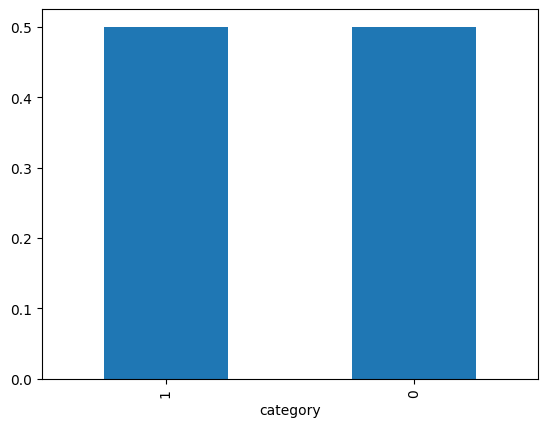

In [5]:
df['category'].value_counts(True).plot.bar();

# See sample image

(367, 424, 3)
255


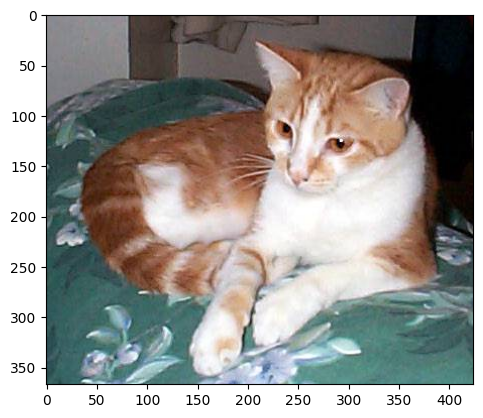

In [6]:
'''
Tres canales para el RGB.
Todas las imagágenes en diferentes resoluciones. Esto es un problema.
Todas tienen que llevar las mismas dimensiones para la entrada a la red
'''
# pip install scikit-image 
from skimage.io import imread
# pip install opencv-python 
import cv2

sample = random.choice(filenames)
image = imread(TRAIN_PATH + sample)

print(image.shape)
print(np.max(image))
plt.imshow(image);

Una imagen no es mas que un array de HxWxC píxeles, siendo H(Height) y W(Width) las dimensiones de resolución de la imagen, y C el número de canales. Habrá tres valores por píxel. 

In [7]:
image

array([[[141, 137, 138],
        [141, 137, 138],
        [139, 137, 142],
        ...,
        [ 47,   7,   7],
        [ 51,   5,   5],
        [ 52,   4,   2]],

       [[141, 137, 138],
        [141, 137, 138],
        [139, 137, 142],
        ...,
        [ 47,   7,   7],
        [ 51,   5,   5],
        [ 52,   4,   2]],

       [[141, 137, 138],
        [141, 137, 138],
        [139, 137, 142],
        ...,
        [ 47,   8,   9],
        [ 50,   6,   7],
        [ 49,   3,   3]],

       ...,

       [[ 39,  81,  79],
        [ 43,  85,  83],
        [ 51,  93,  91],
        ...,
        [ 84, 140, 131],
        [ 83, 139, 128],
        [ 82, 138, 127]],

       [[ 43,  85,  83],
        [ 47,  89,  87],
        [ 53,  95,  93],
        ...,
        [ 83, 139, 130],
        [ 84, 140, 129],
        [ 84, 140, 129]],

       [[ 48,  90,  88],
        [ 51,  93,  91],
        [ 55,  97,  95],
        ...,
        [ 83, 139, 130],
        [ 84, 140, 129],
        [ 85, 141, 130]]

# Resize image
Cargar todas las imágenes a la vez es un problema ya que son un total de 25000 (unos 500MB la carpeta de train). Este proceso require mucha memoria, por lo que tendremos que aplicarle un resize a cada imagen para bajarlas de resolución. Esto también nos sirve para solventar el problema de tener imágenes con distintas resoluciones.

Tamaño imagen original: (375, 499, 3)
Tamaño imagen reshape: (32, 32, 3)
Maximo valor por pixel: 251


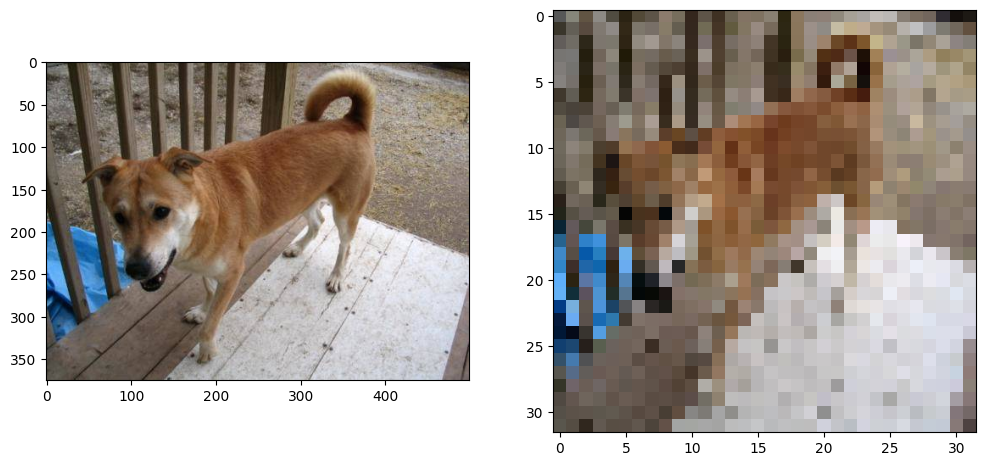

In [8]:
plt.figure(figsize=(12, 12))

sample = random.choice(filenames)
image = imread(TRAIN_PATH + sample)
imagesmall = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))

print("Tamaño imagen original:", image.shape)
print("Tamaño imagen reshape:", imagesmall.shape)
print("Maximo valor por pixel:", np.max(imagesmall))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)

# Resized image
plt.subplot(1, 2, 2)
plt.imshow(imagesmall);

# Color
Podríamos cargar las imágenes como blanco y negro, de esta forma se reduciría el espacio de features considerablemente al contar con un único canal

Dimensiones: (332, 499)
Maximo color: 255


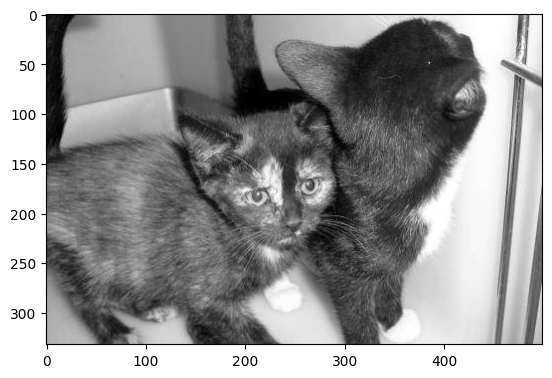

In [9]:
sample = random.choice(filenames)

image = cv2.imread(filename=TRAIN_PATH + sample, flags=cv2.IMREAD_GRAYSCALE)

print("Dimensiones:", image.shape)
print("Maximo color:", np.max(image))
plt.imshow(image,cmap='gray');

# Load data
Llega el momento de cargar los datos. Ya no estan sencillo como cuando teníamos datasets en CSVs puesto que ahora hay que cargar miles de archivos en memoria en este notebook. Para ello necesitaremos un programa iterativo que vaya recorriendo los archivos de la carpeta, cargarlos como array de numpy y almacenarlos en un objeto.

In [10]:
def read_data(path, im_size):
    X = []
    Y = []

    for file in os.listdir(path):
        image = imread(path + '/' + file)
        smallimage = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
        
        X.append(smallimage)
        
        category = file.split('.')[0]
        if category == 'dog':
            Y.append(1)
        else:
            Y.append(0)

    return np.array(X), np.array(Y)
    

X_train, y_train = read_data(TRAIN_PATH, IMAGE_SIZE)
X_test, y_test = read_data(TEST_PATH, IMAGE_SIZE)

print(X_train.shape)
print(X_test.shape)

(25000, 32, 32, 3)
(12500, 32, 32, 3)


(32, 32, 3)


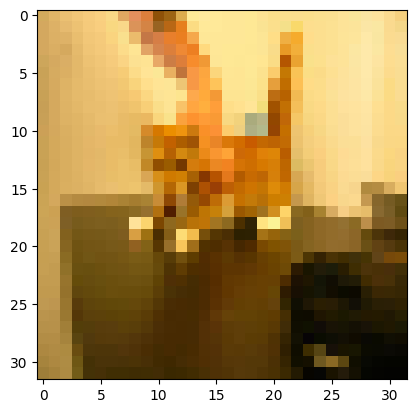

In [11]:
print(X_train[0].shape)
plt.imshow(X_train[0]);

In [12]:
X_train[0]

array([[[210, 171,  93],
        [224, 181, 103],
        [235, 192, 114],
        ...,
        [253, 227, 157],
        [250, 218, 143],
        [245, 208, 127]],

       [[212, 168,  95],
        [221, 177, 102],
        [230, 186, 111],
        ...,
        [250, 231, 162],
        [250, 218, 143],
        [244, 215, 137]],

       [[212, 168,  95],
        [220, 176, 101],
        [222, 178, 103],
        ...,
        [249, 230, 161],
        [251, 219, 144],
        [249, 219, 147]],

       ...,

       [[173, 136,  65],
        [176, 139,  68],
        [173, 139,  65],
        ...,
        [ 10,  10,   2],
        [ 11,  10,   5],
        [  9,   8,   3]],

       [[166, 132,  61],
        [173, 136,  65],
        [174, 140,  68],
        ...,
        [  5,   6,   1],
        [  4,   5,   0],
        [  4,   5,   0]],

       [[158, 126,  57],
        [166, 131,  60],
        [173, 139,  67],
        ...,
        [  4,   4,   1],
        [  3,   3,   1],
        [  3,   3,   1]]

# Normalized data
Normalizar los datos hará que entrene mucho mejor la red, al estar todos los pixeles en la misma escala.

In [13]:
print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 0
Max: 255


In [14]:
X_train = X_train / 255.0
X_test = X_test / 255.0

print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 0.0
Max: 1.0


# Shuffle data
Como hemos cargado los datos de manera ordenada (primero gatos y luego perros), tendremos que desordenarlos para asegurarnos de que no haya ningún sesgo en el entrenamiento ni en la selección de datos de validación.

In [15]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Save data
Podemos guardar los arrays de numpy en un archivo `.npz`, de tal manera que luego sea más rápido importarlo

In [16]:
np.savez(ROOT_PATH + 'data.npz', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Para cargar

In [17]:
data = np.load(ROOT_PATH + 'data.npz')

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

# Build Model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Conv Layer**: extraerá diferentes features de las imagenes
* **Pooling Layer**: Reduce las dimensiones de las imágenes tras una capa convolucional
* **Fully Connected Layer**: Tras las capas convolucionales, aplanamos las features y las introducimos como entrada de una red neuronal normal.
* **Output Layer**: Las predicciones de la red

Para el loss y la metrica, se puede usar un binary_crossentropy, al ser un target binario. O 

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
'''
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
'''

"\nmodel = Sequential()\n\nmodel.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\nmodel.add(Dropout(0.25))\n\nmodel.add(Conv2D(64, (3, 3), activation='relu'))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\nmodel.add(Dropout(0.25))\n\nmodel.add(Conv2D(128, (3, 3), activation='relu'))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\nmodel.add(Dropout(0.25))\n\nmodel.add(Flatten())\nmodel.add(Dense(512, activation='relu'))\nmodel.add(BatchNormalization())\nmodel.add(Dropout(0.5))\nmodel.add(Dense(2, activation='softmax'))\n\nmodel.compile(loss='categorical_crossentropy',\n              optimizer='rmsprop',\n              metrics=['accuracy'])\n"

In [19]:
from tensorflow import keras

layers = [
    keras.layers.Conv2D(64,(3,3), activation = 'relu', input_shape=IMAGE_SIZE),
    keras.layers.MaxPooling2D(pool_size = (2,2)),

    keras.layers.Conv2D(128,(3,3), activation = 'relu'),
    keras.layers.MaxPooling2D(pool_size = (2,2)),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
]

model = keras.Sequential(layers)
'''
sparse_categorical_crossentropy para cuando las categorias vienen en una unica columna
categorical_crossentropy para cuando las categorias vienen en formato dummy
'''
model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

c:\Users\Jonatan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 673,921 (2.57 MB)

 Trainable params: 673,921 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

# Callbacks
#### Early Stopping

In [21]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(patience=10)

# Fit the model

In [22]:
model.fit(X_train,
          y_train,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          callbacks = [earlystop],
          validation_split=0.2)

Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.5615 - loss: 0.6760 - val_accuracy: 0.6964 - val_loss: 0.5771
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.7215 - loss: 0.5472 - val_accuracy: 0.7538 - val_loss: 0.4957
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.7667 - loss: 0.4825 - val_accuracy: 0.7858 - val_loss: 0.4629
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.7993 - loss: 0.4294 - val_accuracy: 0.7770 - val_loss: 0.4832
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8208 - loss: 0.3885 - val_accuracy: 0.7840 - val_loss: 0.4523
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8376 - loss: 0.3576 - val_accuracy: 0.7890 - val_loss: 0.4594
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8698 - loss: 0.2949 - val_accuracy: 0.7790 - val_loss: 0.4915
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8906 - loss: 0

# Evaluate
Probemos los datos en el conjunto de test.

In [23]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4592 - loss: 4.1145
test loss, test acc: [4.125997066497803, 0.4585599899291992]


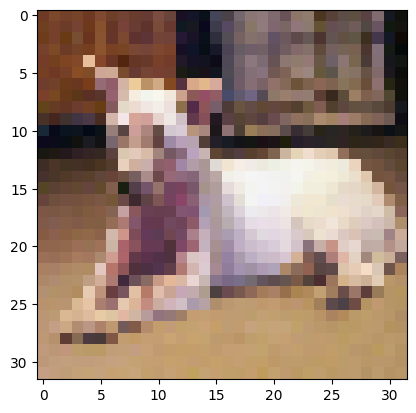

In [24]:
plt.imshow(X_test[8]);

In [25]:
predictions = model.predict(X_test[:10]).round(3)
print("predictions shape:", predictions.shape)
predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
predictions shape: (10, 1)


array([[0.997],
       [0.   ],
       [0.   ],
       [1.   ],
       [1.   ],
       [0.976],
       [0.005],
       [1.   ],
       [0.988],
       [0.   ]], dtype=float32)

# Image data generator

In [26]:
'''
NO genera X imagenes sinteticas. Simplemente en cada epoch, en vez de coger el
dataset tal cual lo tiene, coge una de esas imágenes sintéticas, algo diferentes,
Asi eumentan sus perspectivas
Las imagenes las va generando segun entrena
https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/

'''
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

print("Categorias:", df['category'].unique())
df.head()

Categorias: ['cat' 'dog']


,filename,category
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat
5,cat.10000.jpg,cat


In [27]:
example_df = df.sample(n=1).reset_index(drop=True)

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
)

Found 1 validated image filenames belonging to 1 classes.


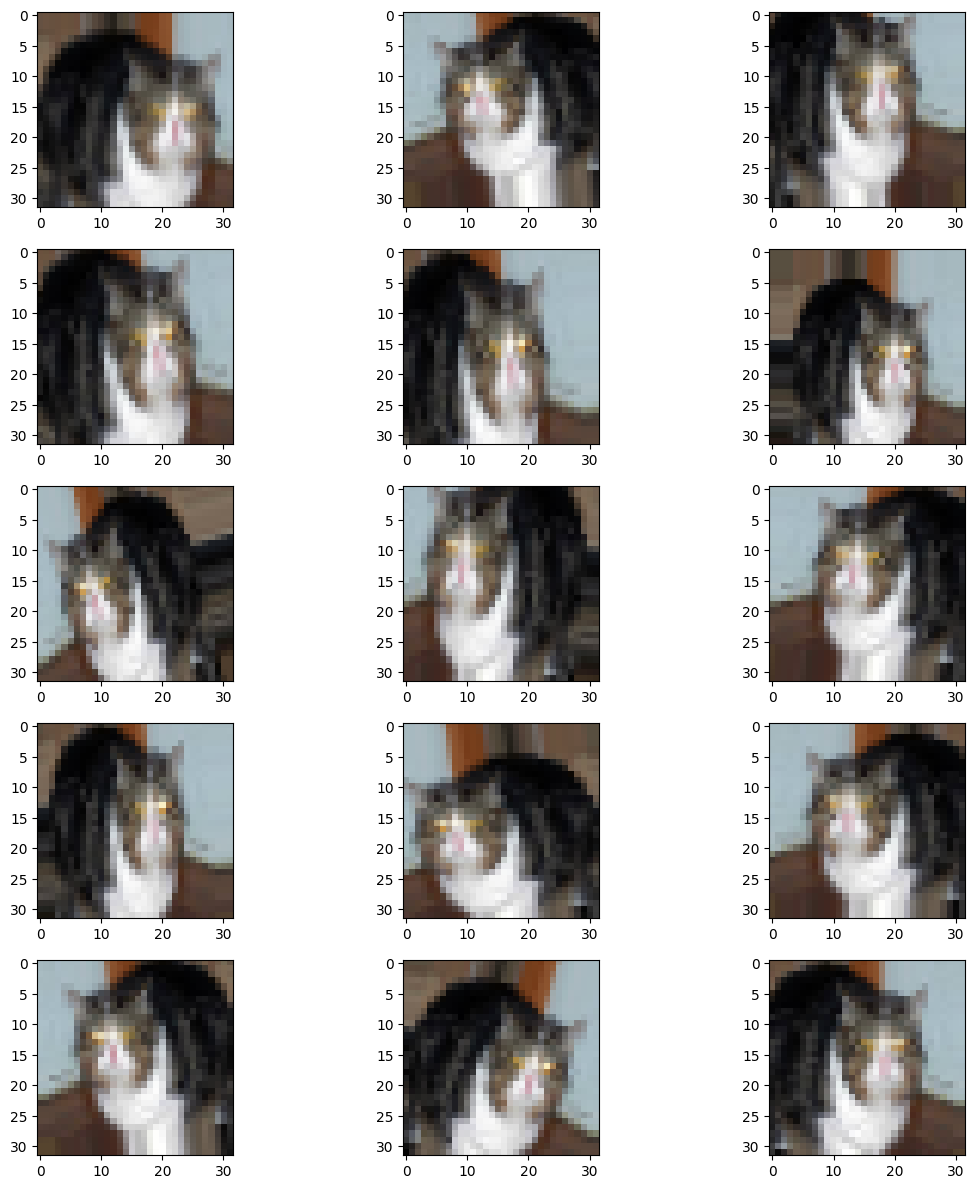

In [28]:
plt.figure(figsize=(12, 12))

for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [29]:
train_df, validate_df = train_test_split(df,
                                         test_size=0.20,
                                         random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [30]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print("Shape train", total_train)
print("Shape validation", total_validate)
validate_df.head()

Shape train 19999
Shape validation 5000


,filename,category
0,cat.4930.jpg,cat
1,dog.5208.jpg,dog
2,cat.7450.jpg,cat
3,dog.11023.jpg,dog
4,dog.11364.jpg,dog


In [31]:
train_df.head()

,filename,category
0,dog.8479.jpg,dog
1,dog.876.jpg,dog
2,cat.10916.jpg,cat
3,dog.10128.jpg,dog
4,cat.11378.jpg,cat


# Training Generator

In [32]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 19999 validated image filenames belonging to 2 classes.


### Validation Generator

In [33]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 19999 validated image filenames belonging to 2 classes.


# Fit Model

In [34]:
model = keras.Sequential(layers)

model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [35]:
history = model.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator
)

Epoch 1/20
  10/2000 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - accuracy: 0.6789 - loss: 1.3593 

c:\Users\Jonatan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - accuracy: 0.7441 - loss: 0.5962 - val_accuracy: 0.7842 - val_loss: 0.4251
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step - accuracy: 0.7665 - loss: 0.4811 - val_accuracy: 0.8085 - val_loss: 0.4058
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 73s 36ms/step - accuracy: 0.7708 - loss: 0.4743 - val_accuracy: 0.8058 - val_loss: 0.4038
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step - accuracy: 0.7870 - loss: 0.4535 - val_accuracy: 0.8504 - val_loss: 0.3394
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 71s 36ms/step - accuracy: 0.7854 - loss: 0.4438 - val_accuracy: 0.8588 - val_loss: 0.3383
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 72s 36ms/step - accuracy: 0.7927 - loss: 0.4507 - val_accuracy: 0.8048 - val_loss: 0.4178
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step - accuracy: 0.7945 - loss: 0.4386 - val_accuracy: 0.8428 - val_loss: 0.3500
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 72s 36ms/step - accuracy: 0.7958 - loss: 0.43

In [36]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4888 - loss: 1.7163
test loss, test acc: [1.7267147302627563, 0.48423999547958374]


# Save Model

In [39]:
model.save_weights("model.weights.h5")

# Visualize Training

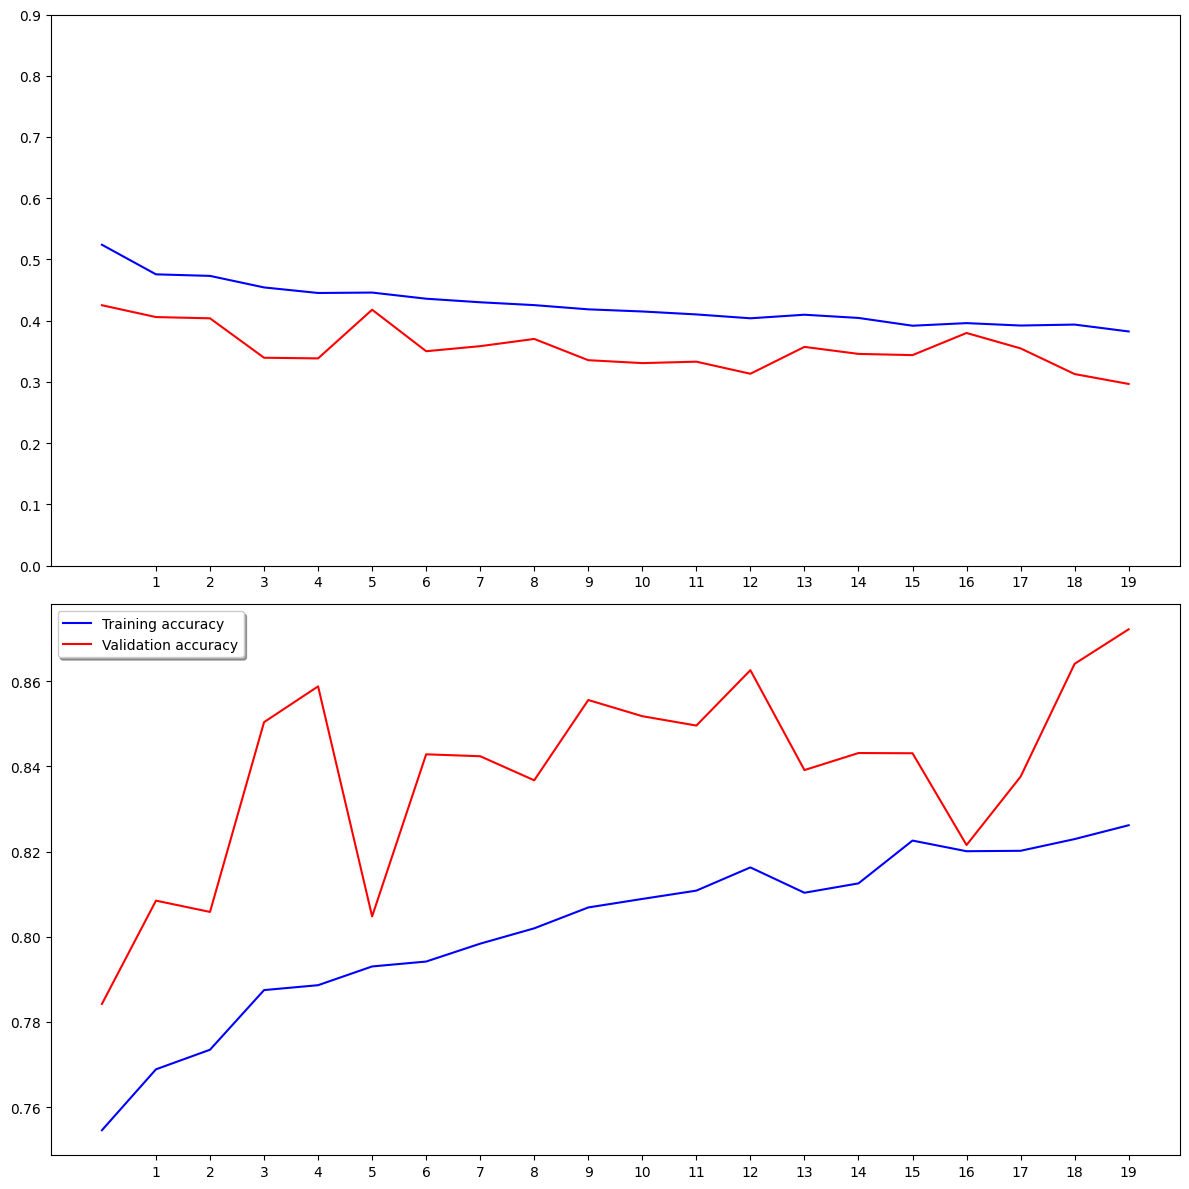

In [40]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, EPOCHS, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, EPOCHS, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

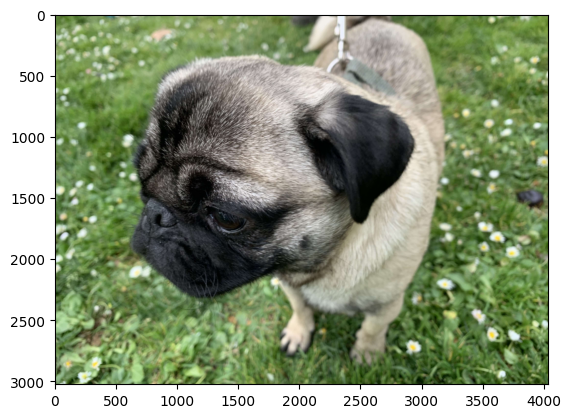

In [ ]:
from skimage.io import imread
# pip install opencv-python 
import cv2

sample = random.choice(filenames)
image = imread('./img/gin.jpg')
plt.imshow(image);

In [ ]:
image = np.array([cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))/255.0])

In [ ]:
predictions = model.predict(image).round(3)
print("predictions shape:", predictions.shape)
predictions